# Will the US Meet July 4, 2021 Vaccine Administration Goals?

On May 4, 2021, United States President Biden announced a goal to administer at least one coronavirus vaccine shot to 70% of the U.S. adult population by July 4th. Read the official statement [here.](https://www.whitehouse.gov/briefing-room/statements-releases/2021/05/04/fact-sheet-president-biden-to-announce-goal-to-administer-at-least-one-vaccine-shot-to-70-of-the-u-s-adult-population-by-july-4th/)

Per the briefing, the White House's vaccine campaign actions to reach this goal include:
- **Making access to vaccinations more convenient** by increasing walk-in vaccinations at local pharmacies across the nation and moving to smaller, community-based and mobile vaccination clinics
- **Supporting community vaccine education and local outreach efforts** by expanding the workforce of community-based organizations, supporting underserved communities with the tools needed to get vaccinated, and supporting the next phase of state and local vaccine outreach efforts
- **Providing easier access to those living in rural communities and bolster efforts to reach rural Americans in the response** by shipping new allocations of vaccine to rural health clinicas, increasing vaccine education and outreach efforts in rural communities, and increasing funding for rural health clinics and hospitals to respond to COVID-19 with testing and mitigation measures
- **Launch a comprehensive plan to vaccinate the nation’s adolescents, should the FDA authorize a vaccine for younger ages**

Here we will conduct a time series analysis on the CDC's public vaccine distribution and administration dataset as of June 13, 2021 to predict whether or not the US will meet the target, then suggest which states/jurisdictions to focus vaccine campaign actions in the final 3 weeks in order to reach the goal.

In [1]:
# styling notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [2]:
# import standard packages
import pandas as pd
pd.set_option('display.max_columns', 0)
import numpy as np

#import viz packages
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5) #setting figures to timeseries-friendly

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Time Series Tools from statsmodels
import statsmodels.tsa.api as tsa
import statsmodels
print(f'Statsmodels version = {statsmodels.__version__}')

# set random seed
rs=610
np.random.seed(rs)

Statsmodels version = 0.12.0


# Load Data

## Data Source

Data was sourced from the CDC's [official COVID-19 Vaccination dataset](https://data.cdc.gov/Vaccinations/COVID-19-Vaccinations-in-the-United-States-Jurisdi/unsk-b7fc), on June 13, 2021.

Description of the data source:

> Overall US COVID-19 Vaccine deliveries and administration data at national and jurisdiction level. Data represents all vaccine partners including jurisdictional partner clinics, retail pharmacies, long-term care facilities, dialysis centers, Federal Emergency Management Agency and Health Resources and Services Administration partner sites, and federal entity facilities. 

## Notes:

- "Adults" defined as 18+
- To estimate the 12+, 18+ and 65+ populations for US territories, CDC assumes that the proportions of people aged 12 years and older, 18 years and older and people aged 65 years and older in the territories are the same as in the aggregate of the 50 states, DC, and Puerto Rico (85%, 78% and 17%, respectively).
- Vaccination data on CDC’s COVID Data Tracker are typically at least 48 hours behind a state’s vaccination data reports.
- Focusing just on 50 states, District of Columbia, and Puerto Rico

In [3]:
full_dataset = pd.read_csv('./data/COVID-19_Vaccinations_in_the_United_States_Jurisdiction.csv')
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11798 entries, 0 to 11797
Data columns (total 69 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Date                                    11798 non-null  object 
 1   MMWR_week                               11798 non-null  int64  
 2   Location                                11798 non-null  object 
 3   Distributed                             11798 non-null  int64  
 4   Distributed_Janssen                     11798 non-null  int64  
 5   Distributed_Moderna                     11798 non-null  int64  
 6   Distributed_Pfizer                      11798 non-null  int64  
 7   Distributed_Unk_Manuf                   11798 non-null  int64  
 8   Dist_Per_100K                           11798 non-null  int64  
 9   Distributed_Per_100k_12Plus             11798 non-null  int64  
 10  Distributed_Per_100k_18Plus             11798 non-null  in

There are no null values in the dataset.

Next step: select features.

In [4]:
full_dataset.columns

Index(['Date', 'MMWR_week', 'Location', 'Distributed', 'Distributed_Janssen',
       'Distributed_Moderna', 'Distributed_Pfizer', 'Distributed_Unk_Manuf',
       'Dist_Per_100K', 'Distributed_Per_100k_12Plus',
       'Distributed_Per_100k_18Plus', 'Distributed_Per_100k_65Plus',
       'Administered', 'Administered_12Plus', 'Administered_18Plus',
       'Administered_65Plus', 'Administered_Janssen', 'Administered_Moderna',
       'Administered_Pfizer', 'Administered_Unk_Manuf', 'Administered_Fed_LTC',
       'Administered_Fed_LTC_Residents', 'Administered_Fed_LTC_Staff',
       'Administered_Fed_LTC_Unk', 'Administered_Fed_LTC_Dose1',
       'Administered_Fed_LTC_Dose1_Residents',
       'Administered_Fed_LTC_Dose1_Staff', 'Administered_Fed_LTC_Dose1_Unk',
       'Admin_Per_100K', 'Admin_Per_100k_12Plus', 'Admin_Per_100k_18Plus',
       'Admin_Per_100k_65Plus', 'Recip_Administered',
       'Administered_Dose1_Recip', 'Administered_Dose1_Pop_Pct',
       'Administered_Dose1_Recip_12Plus'

# EDA & Preprocessing

EDA & Preprocessing Steps:
1. Select feature to analyze
1. Convert date feature to datetime data type
1. Process out some locations 
1. Create dataframes for 3 analyses:
    - National
    - By State
    - By Region
1. Visualize the trend in vaccine administration as of 6/13/2021 for each of the 3 subsets
    
    
_________
**Select Feature To Analyze**

Of the features available, the one that matches most closely to the goal is **Administered_Dose1_Pop_Pct,** which represents the percent of population with at lease one dose based on the jurisdiction where recipient lives.

In [5]:
#create a dataframe with only the target feature, date, and location
ts1 = full_dataset[['Date', 'Location', 'Administered_Dose1_Pop_Pct']]
ts1.head()

,Date,Location,Administered_Dose1_Pop_Pct
0,06/13/2021,ND,43.0
1,06/13/2021,DE,56.3
2,06/13/2021,GA,41.3
3,06/13/2021,WA,58.8
4,06/13/2021,NM,59.2


_______

**Convert Date Feature to `datetime` Data Type**


In [6]:
# convert Date column to datetime data type
ts1['Date'] = pd.to_datetime(ts1['Date'])
ts1.head()

<ipython-input-6-a3439b115a7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts1['Date'] = pd.to_datetime(ts1['Date'])


,Date,Location,Administered_Dose1_Pop_Pct
0,2021-06-13,ND,43.0
1,2021-06-13,DE,56.3
2,2021-06-13,GA,41.3
3,2021-06-13,WA,58.8
4,2021-06-13,NM,59.2


_____

**Process Out Some Locations**


In [7]:
#explore jurisdictions represented in the dataset
locs = sorted(list(ts1.Location.unique()))
print(len(locs))
print(locs)

65
['AK', 'AL', 'AR', 'AS', 'AZ', 'BP2', 'CA', 'CO', 'CT', 'DC', 'DD2', 'DE', 'FL', 'FM', 'GA', 'GU', 'HI', 'IA', 'ID', 'IH2', 'IL', 'IN', 'KS', 'KY', 'LA', 'LTC', 'MA', 'MD', 'ME', 'MH', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'RP', 'SC', 'SD', 'TN', 'TX', 'US', 'UT', 'VA', 'VA2', 'VI', 'VT', 'WA', 'WI', 'WV', 'WY']


This analysis will focus on the 50 US states, DC, and Puerto Rico. Other jurisdictions included in the original dataset were US-owned teritories and federal entities.

In [8]:
#remove US territories
locs.remove('AS') #remove American Samoa
locs.remove('FM') #remove Federated States of Micronesia
locs.remove('GU') #remove Guam
locs.remove('MH') #remove Marshall Islands
locs.remove('MP') #remove Northern Mariana Islands
locs.remove('RP') #remove Palau
locs.remove('VI') #remove US Virgin Islands
#remove federal entities
locs.remove('BP2') #bureau of prisons
locs.remove('DD2') #dept of defense
locs.remove('IH2') #indian health services
locs.remove('LTC') #long term care
locs.remove('VA2') #veterans health
#remove US total to use this as a list of the sub-jurisdictions
locs.remove('US') 

In [9]:
print(len(locs))
print(locs)

52
['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'PR', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']


______

**Create Dataframes & Visualizations To Analyze National Trends, Trends By State, & Trends By Region**

In [24]:
# define a function to consistently plot the target timeframe and visualize the goal

def plot_vax(ts, title, labels, color=None):
    #plot timeseries in range
    fig = px.line(ts, color=color, title=title, range_x=('2021-02-01', '2021-07-21'), labels=labels)

    #plot vertical line at 6/13/21 to indicate data observed by
    fig.add_trace(go.Scatter(
        x=['2021-06-13', '2021-06-13', '2021-06-13'],
        y=[0, 81, 79],
        mode="lines+text",
        line=go.scatter.Line(color='gray', dash='dash'),
        name='Data Observed as of 6/13',
        text=[None, "<-- Observed", 'Predicted -->'],
        textposition="top center",
        textfont={'size':10}))

    #plot horizontal line at goal of 70% first dose administered
    fig.add_trace(go.Scatter(
        x=[0, '2021-04-20', '2021-07-04'],
        y=[70, 70, 70],
        mode="lines+text",
        line=go.scatter.Line(color='black'),
        name="% goal - 70%",
        text=[None, "% goal - 70%", None],
        textposition="top center",
        textfont={'size':12}))

    #plot horizontal line at goal of 70% first dose administered
    fig.add_trace(go.Scatter(
        x=['2021-07-04', '2021-07-04'],
        y=[0, 70],
        mode="lines+text",
        line=go.scatter.Line(color='black'),
        name="Date goal - 7/4/21",
        text=[None, "Date goal - 7/4/21", None],
        textposition="top center",
        textfont={'size':12}))
    
    #styling
    fig.update_layout(plot_bgcolor='#f2f2f2', height=600, width=1000)
    
    #save fig
    fig.write_image(f'./images/{title}.jpg')
    
    return fig

## National Vaccine Administration

In [10]:
# parse out the national data for modeling & analysis
ts1_national = ts1[ts1['Location'] == 'US']
ts1_national.set_index('Date', inplace=True)
ts1_national

,Location,Administered_Dose1_Pop_Pct
Date,,
2021-06-13,US,52.4
2021-06-12,US,52.2
2021-06-11,US,52.0
2021-06-10,US,51.9
2021-06-09,US,51.8
...,...,...
2020-12-17,US,0.0
2020-12-16,US,0.0
2020-12-15,US,0.0


In [25]:
# plot national 
plot_vax(ts=ts1_national.drop(columns='Location'), 
         title="National Trend in Vaccine Administration (% of US pop rec'd 1 or more doses)",
         labels={'value': '% of US Pop', 'variable': 'Legend'})

## Vaccine Administration by State

In [27]:
# create a separate dataframe with only the 50 states + DC + PR
ts1_states = ts1[ts1['Location'] == locs[0]]
for x in locs[1:]:
    ts1_states = pd.concat([ts1_states, ts1[ts1['Location'] == x]], axis=0)

ts1_states.set_index('Date', inplace=True)

In [28]:
ts1_states

,Location,Administered_Dose1_Pop_Pct
Date,,
2021-06-13,AK,47.3
2021-06-12,AK,47.2
2021-06-11,AK,47.1
2021-06-10,AK,47.0
2021-06-09,AK,46.9
...,...,...
2020-12-18,WY,0.0
2020-12-17,WY,0.0
2020-12-16,WY,0.0


In [29]:
# visualize states
plot_vax(ts1_states, 
         color='Location', 
         title="Trend in Vaccine Administration by State (% of state pop rec'd 1 or more doses)", 
         labels={'value': '% of State Pop'})

## Vaccine Administration by Region

In [16]:
#create region lists
northeast = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']
midwest = ['IN', 'IL', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']
south = ['DE', 'DC', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'WV', 'AL', 'KY', 'MS', 'TN', 
         'AR', 'LA', 'OK', 'TX', 'PR']
west = ['AZ', 'CO', 'ID', 'NM', 'MT', 'UT', 'NV', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']

#check that I got all locations
len(northeast+midwest+south+west)

52

In [17]:
#define function to determine region given state, to use in a lambda function and apply to the whole dataframe
def region(state):
    region = str()
    if state in northeast:
        region = 'Northeast'
    if state in midwest:
        region = 'Midwest'
    if state in south:
        region = 'South'
    if state in west:
        region = 'West'
    return region

In [18]:
#check the function works as intended
region(ts1_states.Location[0])

'West'

In [19]:
#map function to all rows in the states df
ts1_states['Region'] = ts1_states.Location.map(lambda x: region(x))

In [20]:
#check that the map function worked
ts1_states.Region.value_counts()

South        3276
West         2366
Midwest      2184
Northeast    1638
Name: Region, dtype: int64

In [21]:
#drop state column and reset index
ts1_region = ts1_states.drop(columns='Location').reset_index()
#multi-index the data by date, then region. Reset the index in order to plot using plotly
ts1_region = ts1_region.groupby(['Date', 'Region']).mean().reset_index().set_index('Date')

In [30]:
plot_vax(ts1_region, 
        color='Region',
        title="Trend in Vaccine Administration by Region (% of region pop rec'd 1 or more doses)",
        labels={'value': '% of Region Pop'})

# National Time Series Analysis

In [31]:
ts1_national

,Location,Administered_Dose1_Pop_Pct
Date,,
2021-06-13,US,52.4
2021-06-12,US,52.2
2021-06-11,US,52.0
2021-06-10,US,51.9
2021-06-09,US,51.8
...,...,...
2020-12-17,US,0.0
2020-12-16,US,0.0
2020-12-15,US,0.0


In [49]:
def adftest(ts):
    results = tsa.stattools.adfuller(ts)
    stats = ['Test Stat', 'p-value', 'k-lags', 'n-observations']
    results_dict = dict(zip(stats, results[:4]))
    results_dict['Stationary?'] = results_dict['p-value']<.05
    results_df = pd.DataFrame(results_dict, index=['AD Fuller Test'])
    return results_df

def stationarity_check(ts, window=8, color=None):
    
    # Calculate rolling statistics
    roll_mean = ts.rolling(window=window, center=False).mean()
    roll_std = ts.rolling(window=window, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adftest(ts)

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    plt.plot(ts, color='black',label=f'Original')
    plt.plot(roll_mean, color='red', label=f'Rolling Mean (window={window})')
    plt.plot(roll_std, color='blue', label = f'Rolling Std (window={window})')
    plt.xlim(left='2021-02-01', right='2021-07-21')
    plt.axvline('2021-06-13', color='gray')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    display(dftest)
    plt.show(block=False)
    

### Random Walk

In [52]:
#create a random walk by using the .diff() method
ts1_national_rw = ts1_national.drop(columns='Location').diff().dropna()

<AxesSubplot:xlabel='Date'>

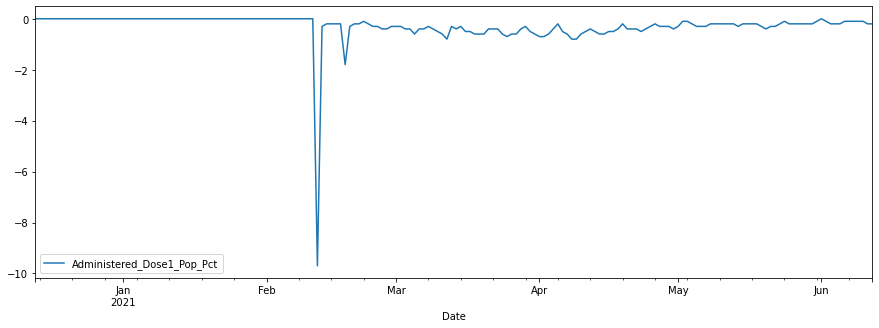

In [53]:
ts1_national_rw.plot();

,Test Stat,p-value,k-lags,n-observations,Stationary?
AD Fuller Test,-12.641012,1.434958e-23,0,181,True


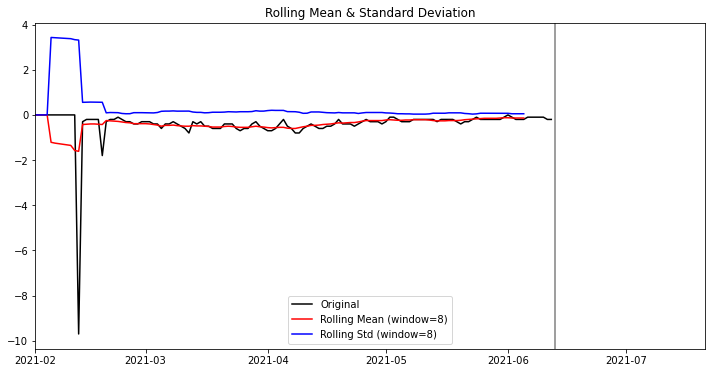

In [54]:
stationarity_check(ts1_national_rw)

Random walk does become stationary.

### Search Optimal Autoregression and Moving Average Parameters

In [59]:

def acf_pacf_plot(ts):
    #plot ACF; cut=MA(q), train=AR(p)
    fig, ax = plt.subplots(figsize=(16,3))
    tsa.graphics.plot_acf(ts, ax=ax, lags=50);
        # a sharp drop after lag=k suggests an MA(k) model, k=q
        # correlation up until lag=k, then trailing off suggests an AR-k model, k=p
    
    #plot PACF; cut=AR(p), trail=MA(q)
    fig, ax = plt.subplots(figsize=(16,3))
    tsa.graphics.plot_pacf(ts, ax=ax, lags=50);
        # a sharp drop after lag=k suggests an AR-k model, k=p
        # correlation up until lag=k, then trailing off suggests an MA-k model, k=q

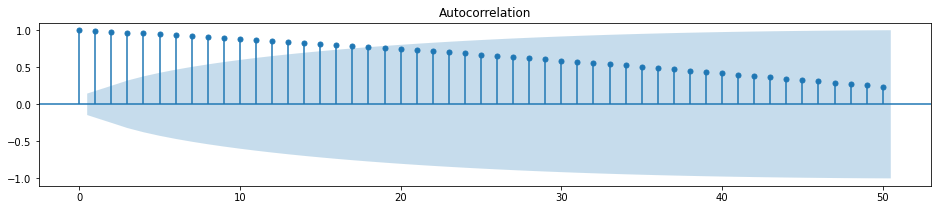

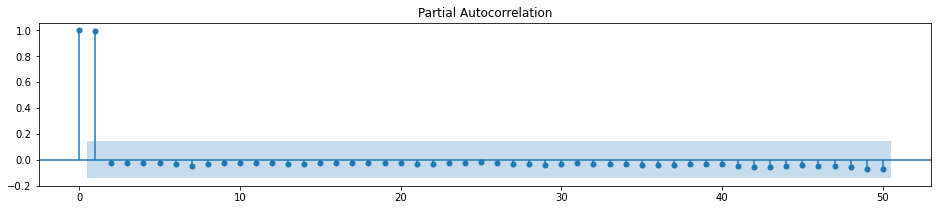

In [61]:
acf_pacf_plot(ts1_national.drop(columns='Location'))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

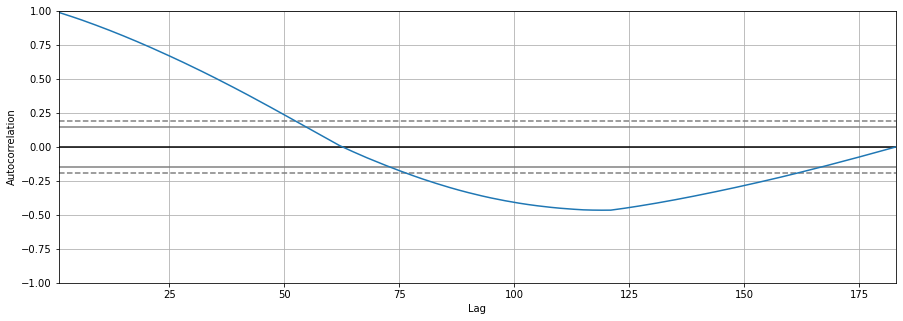

In [62]:
pd.plotting.autocorrelation_plot(ts1_national.drop(columns='Location'))

p=1, q=0

In [100]:
import itertools

p = d = q = range(0,3) #set the range based on PACF and ACF
pdq = list(itertools.product(p, d, q)) #generate all different combinations of p, q and q triplets
#loop through the parameter combinations and collect AIC value
results = []
for comb in pdq:
    model = tsa.arima.ARIMA(ts1_national.drop(columns='Location'), order=comb,
                  enforce_invertibility=False, enforce_stationarity=False)
    output = model.fit()
    results.append([comb, output.aic])

#convert results to a dataframe, sort by AIC smallest to largest
results_df = pd.DataFrame(results, columns=['order', 'AIC']).sort_values('AIC')
order = results_df.iloc[0]['order']
results_df

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency -1D will be used.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency -1D will be used.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_mod

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency -1D will be used.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency -1D will be used.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_mod

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency -1D will be used.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency -1D will be used.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_mod

,order,AIC
7,"(0, 2, 1)",406.901150
8,"(0, 2, 2)",407.648605
19,"(2, 0, 1)",407.752526
16,"(1, 2, 1)",408.901155
17,"(1, 2, 2)",409.441156
20,"(2, 0, 2)",409.644635
13,"(1, 1, 1)",409.675066
14,"(1, 1, 2)",410.419842
26,"(2, 2, 2)",411.441129
22,"(2, 1, 1)",411.675070


### ARIMA Model

In [101]:
national_model = tsa.arima.ARIMA(ts1_national.drop(columns='Location'), order=(0,2,1), 
                                enforce_invertibility=False, enforce_stationarity=False).fit()
national_model.summary()

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency -1D will be used.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency -1D will be used.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:585: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/Users/kristincooper/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_mod

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   SARIMAX Results                                    
======================================================================================
Dep. Variable:     Administered_Dose1_Pop_Pct   No. Observations:                  183
Model:                         ARIMA(0, 2, 1)   Log Likelihood                -201.451
Date:                        Thu, 17 Jun 2021   AIC                            406.901
Time:                                13:09:48   BIC                            413.276
Sample:                                     0   HQIC                           409.486
                                        - 183                                         
Covariance Type:                          opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0561      0.047    -22.630      0.000      -1.148      -0.965
sigma2         0.4949      0.041     12.021      0.000       0.414       0.576
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            140586.61
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               8.66   Skew:                           -11.02
Prob(H) (two-sided):                  0.00   Kurtosis:                       138.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

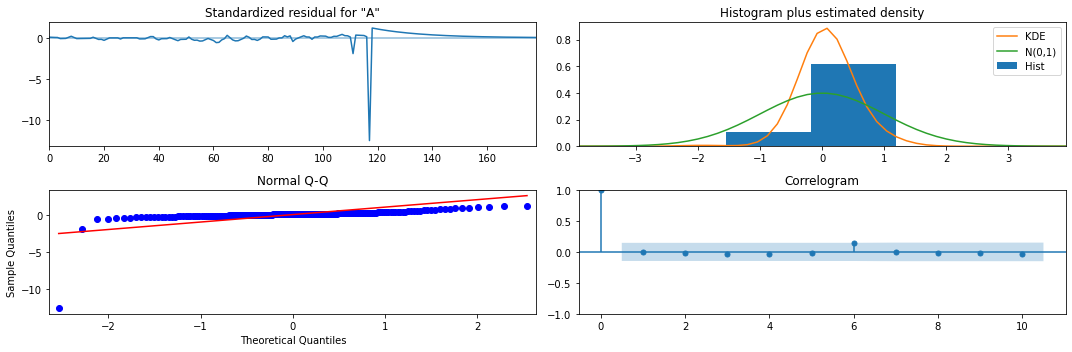

In [102]:
national_model.plot_diagnostics()
plt.tight_layout();

### Validate

In [86]:
pd.to_datetime('2021-07-04') - pd.to_datetime('2021-06-13')

Timedelta('21 days 00:00:00')

In [89]:
import datetime
pd.to_datetime('2021-06-13') - datetime.timedelta(days=21)

Timestamp('2021-05-23 00:00:00')

In [108]:
start = pd.to_datetime('2021-05-23') #date to start
end = pd.to_datetime('2021-06-13') #date to end
pred = national_model.get_prediction()
pred_ci = pred.conf_int()


In [119]:
pd.DataFrame(pred.predicted_mean)

,predicted_mean
Date,
2021-06-13,0.000000
2021-06-12,87.333333
2021-06-11,52.000011
2021-06-10,51.800006
2021-06-09,51.733502
...,...
2020-12-17,-0.041762
2020-12-16,-0.039544
2020-12-15,-0.037443


In [126]:
fig = plot_vax(ts1_national.drop(columns='Location'), title=None, labels=None)
fig.add_trace(go.Scatter(dict(pred.predicted_mean)), mode='line')

TypeError: _process_kwargs() keywords must be strings

NameError: name 'pred_conf' is not defined

<Figure size 1008x432 with 0 Axes>

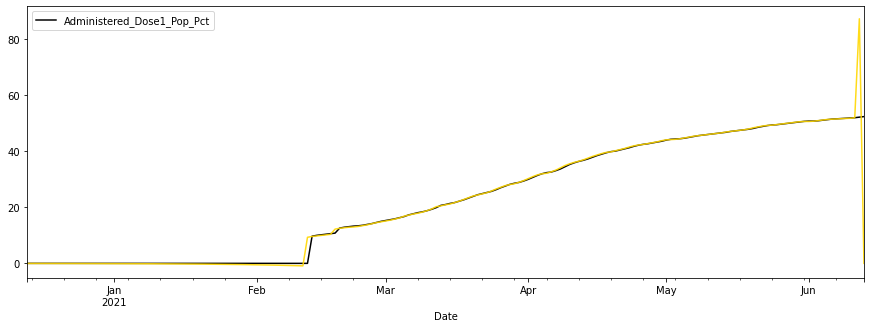

In [111]:
    #plot predictions vs actual values
fig = plt.figure(figsize=(14,6))
ax = ts1_national.drop(columns='Location').plot(label='actual', color='black')
pred.predicted_mean.plot(ax=ax, label='one step ahead forecast', alpha=.9, color='gold')
ax.fill_between(pred_conf.index, pred_conf.iloc[:,0], pred_conf.iloc[:,1], color='g', alpha=.3, 
                label='confidence interval')
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime(start), forecasted_values.index[-1], alpha=.1,
                zorder=-1, color='green')
ax.legend()

# Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# APPENDIX

In [ ]:
#COMMENTED OUT - THIS IS TOTAL POP, NOT JUST ADULT POP
# source: US Census, 2019 estimates. TableID DP05. 
# https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/
# 50 states + District of Columbia + Puerto Rico

# us_adult_pop = 328239523 